# 09-05 - Feed forward neural networks

*June 26 2024*  

Starting from the simple perceptron model implemented in the previous notebook, we now create a model that consists of multiple layers of perceptrons. While a single-layer perceptron model can only learn linear decision boundaries, we can use multi-layer generalizations to learn arbitrary patterns (based on the ability of multi-layer neural networks to approximate any continuous function). Building on what we learned in the previous notebook, we will implement our model in pytorch, using stochastic gradient descent and automatic gradient computation via backpropagation.

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

import pathpy as pp
import scipy as sp

np.set_printoptions(precision=4)
plt.style.use('default')
sns.set_style("whitegrid")

In the previous notebooks, we used a maximally simple data set with (i) a single input feature and (ii) a very simple pattern that allowed classes to be separated by a simple perceptron model. Let us now consider an example with two features $x$ and $y$ and a pattern that requires a non-linear decision boundary. We will show that a multi-layer perceptron model is able to learn this decision boundary.

To generate this data set, we use the function `make_circles` in `sklearn.datasets`.

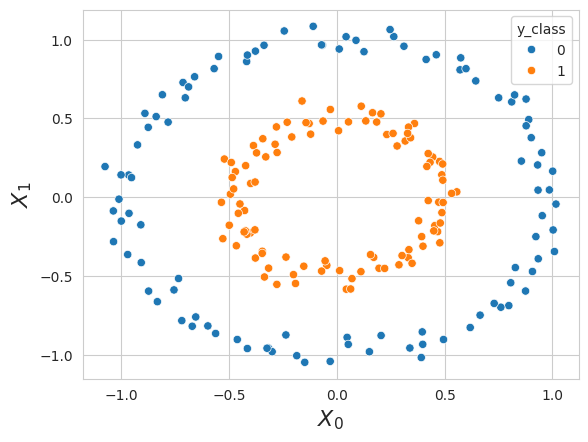

In [2]:
x, c = make_circles(n_samples=200, noise = 0.05, factor = 0.5)
data = pd.DataFrame( {'x0': x[:,0], 'x1': x[:,1], 'y_class': c })

sns.scatterplot(x='x0', y='x1', data=data, hue='y_class')
plt.xlabel(r'$X_0$', fontsize=16)
plt.ylabel(r'$X_1$', fontsize=16);

We can further use `sklearn` functions to generate a train-test split of our data set:

In [3]:
train, test = train_test_split(data, train_size=0.8)

In [4]:
train_features = train[['x0', 'x1']]
train_labels = train[['y_class']]

print("\nTraining features:")
print(train_features.values[:5])
print("\nTraining class labels: ")
print(train_labels.values[:5])


Training features:
[[-0.1487 -1.0494]
 [ 0.3389 -0.9584]
 [ 0.0643 -0.5837]
 [ 0.4448  0.254 ]
 [-0.9699 -0.3651]]

Training class labels: 
[[0]
 [0]
 [1]
 [1]
 [0]]


In [5]:
train_features = torch.tensor(train_features.values, dtype=torch.float32)
train_labels = torch.tensor(train_labels.values, dtype=torch.float32)

In [6]:
class Perceptron(torch.nn.Module):
    
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(in_features=2, out_features=1, bias=True)
        
    def forward(self, x):
        # we use a logistic transformation to output class probabilities        
        return torch.special.expit(self.linear(x))

# create perceptron and configure learning process
model = Perceptron()

# we use the mean absolute diff between target and prediction as loss function
loss_func = torch.nn.MSELoss()

# the number of epochs gives the number of times we run the 
# optimization algorithm on all examples in our training set
epochs = 100

# the learning rate controls how much parameters are 
# changed (based on the gradients) for each training sample
learning_rate = 0.1

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

bias = tensor([0.1069])
weight = tensor([[ 0.2762, -0.0453]])


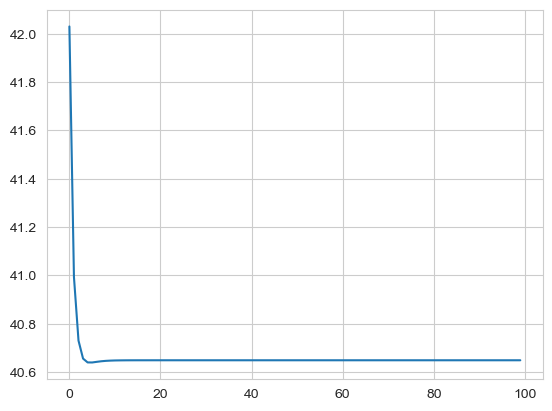

In [13]:
# Set network to training mode
model.train()

errors = []

for epoch in range(epochs):

    error = 0 
    for i in range(len(train_features)):
        x = train_features[i].reshape(2,)
        label = train_labels[i].reshape(1,)

        # set gradients to zero
        optimizer.zero_grad()

        # compute output and loss function
        output = model(x)
        loss = loss_func(output, label)

        # apply backpropagation to output tensor, which will 
        # automatically compute gradients of model parameters
        loss.backward()

        # update model parameters based on computed gradients
        optimizer.step()

        error += loss

    errors.append(error.detach().numpy())

plt.plot(range(epochs), errors)

print('bias =', model.linear.bias.data)
print('weight =', model.linear.weight.data)

In [7]:
def predict(prob):
    if prob>=0.5:
        return 1
    else:
        return 0

<Axes: xlabel='x0', ylabel='x1'>

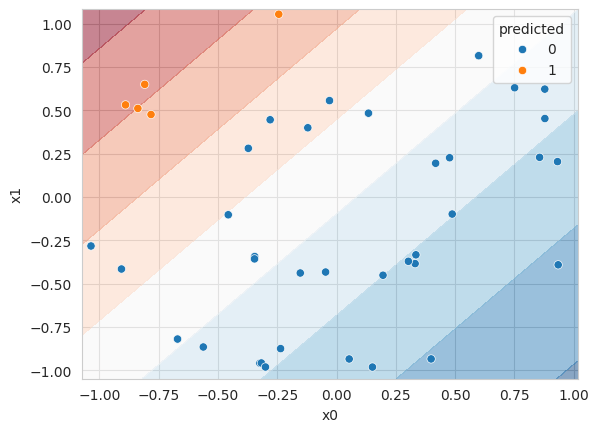

In [8]:
min_x = data['x0'].min()
min_y = data['x1'].min()

max_x = data['x0'].max()
max_y = data['x1'].max()

x_mesh, y_mesh = np.meshgrid(np.linspace(min_x, max_x, 100), np.linspace(min_y, max_y, 100))
class_probs = model(Variable(torch.from_numpy(np.c_[x_mesh.ravel(), y_mesh.ravel()]).float()))
#print(logits)

#probs = torch.softmax(logits, dim=0)
z = np.array(class_probs.detach().numpy()).reshape(x_mesh.shape)

test['predicted'] = [predict(x) for x in model(torch.from_numpy(test[['x0','x1']].values).float()).detach().numpy()]

fig, ax = plt.subplots()
ax.contourf(x_mesh, y_mesh, z, cmap='RdBu_r', alpha=0.5)
sns.scatterplot(x='x0', y='x1', data=test, hue='predicted')

## Feed-forward neural networks

Building on the lecture, we now implement a feed-forward neural network that consists of three layers, where all "neurons" in one layer are connected to each "neuron" in the subsequent layer. 

1) The input layer consists of two inputs that represent the two features in our data. Each of those inputs is fed into each perceptron in the hidden layer. Note that the nodes in the input layer are actually not perceptrons. They are just nodes that represent the input variables, which is why our model actually only has two layers of perceptrons (and associated weight parameters).

2) The hidden layer consists of multiple perceptrons, where each perceptron receives all inputs and generates a single output (calculated based on a linear combination and a and an activation function) that is forwarded to each of the output nodes.

3) The output layer consists of (possibly) multiple perceptrons, where each perceptron receives all outputs of the hidden layer as input, generating one output variable. In our example of a binary classifier, we only have a single output variable and thus only a single perceptron in the output layer.

We see that this architecture actually consists of one input layer as well as two layers of perceptrons, for which we can use the `torch.nn.Linear` class. We implement this in the following `torch` module.

In the function `forward` we first pass the input features to the hidden layer. We apply a non-linear activation function to the linearly transformed inputs, which generates the output of the hidden layer. We then pass this as input to the second layer. We can choose the number of hidden neurons in the hidden layer, which is independent both from the dimensions of the input and the number of output variables.

In [17]:
class FFNet(torch.nn.Module):
    
    def __init__(self, in_ch, hidden_dim, out_ch):        
        super(FFNet, self).__init__()

        # each of the two layers applies a linear transformation y = x A^T + b to its input variables x, 
        # where b is bias, and y is output

        # A is a matrix that captures the weights of connections (i.e. the slope of the linear model) of the input variables

        # this generates hidden_dim perceptrons, each receiving in_ch inputs
        self.in2hidden = torch.nn.Linear(in_features=in_ch, out_features=hidden_dim, bias=True)

        # this generates out_ch perceptrons, each receiving hidden_dim inputs
        self.hidden2out = torch.nn.Linear(in_features=hidden_dim, out_features=out_ch, bias=True)
    
    def forward(self, x):        
        
        hidden = self.in2hidden(x)

        # we can use different non-linear activation functions. Here we use the
        # sigmoid function, which maps to an output from 0 to 1 that can be interpreted
        # as class probability (analogous to the logistic function in logistic regression)
        hidden = torch.sigmoid(hidden)

        # we pass this as input to the output layer
        output = self.hidden2out(hidden)

        # we finally apply a sigmoid activation function, which yields a single 
        # output that can be interpreted as class probability
        output = torch.sigmoid(output)

        return output

To test our (untrained) model, we can pass the features of a single data point.

In [18]:
model = FFNet(in_ch=2, hidden_dim=6, out_ch=1)

x = train_features[0].reshape(1,2)

model.forward(x)

tensor([[0.4387]], grad_fn=<SigmoidBackward0>)

We can now train our model. Following the previous notebook, for this we need: 

1) A loss function to evaluate the current performance of our model. Note that the loss function must be chosen such that it fits the output of our model. Here, by using the sigmoid activation function and a single output variable, our model outputs the probability of a class (e.g. class 1). Here, we can use the binary cross entropy loss function, which 

2) Gradients of all our model parameters, which are automatically calculated by the `autograd` module when we backpropagate the loss function

3) An optimization algorithm that uses those gradients to optimize the model parameters. Here we will again use the Stochastic Gradient Descent implementation included in `pytorch`.

In [25]:
# train model
epochs = 200
lrn_rate = 0.1
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lrn_rate)

In [26]:
print("\nStarting training ")

# Set network to training mode
model.train()

indices = np.arange(160)

losses = []

# one epoch is a complete run of the optimization algorithm
for epoch in range(epochs):
    error = 0
    # in each epoch, we use one `batch` of training samples
    np.random.shuffle(indices)
    for i in indices:

        X = train_features[i].reshape(1,2)
        Y = train_labels[i]
        
        # sets gradients to zero
        optimizer.zero_grad()

        output = model(X)        
        loss = loss_func(output[0], Y)

        # the backward propagation function
        # propagates the error (calculated by the 
        # loss function) backwards through the network

        # autograd will calculate gradients in the 
        # of parameters and store them in the .grad property        
        # parameter gradients are calculated based on partial derivatives of the 
        # loss and activation function
        loss.backward()
        error += loss.detach().numpy()

        # perform parameter update based on current gradients
        # and update rule of optimization algorithm
        optimizer.step()

    losses.append(error)

print("Finished training.")


Starting training 
Finished training.


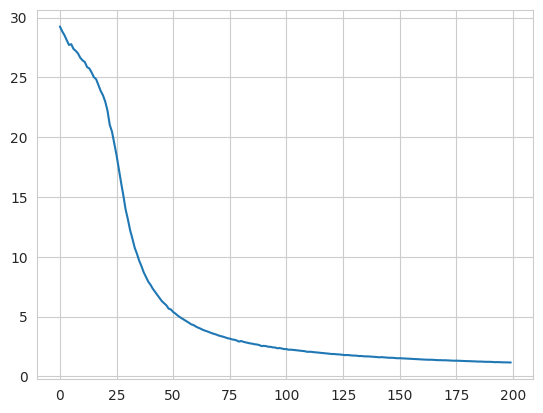

In [27]:
plt.plot(range(epochs), losses)

In [28]:
def predict(prob):
    if prob>0.5:
        return 1
    else:
        return 0

In [29]:
# Set network to evaluation mode
model.eval()

feature = test[['x0', 'x1']].values[0]

print("\nPredicting class for: ", feature)

# create tensor
t = torch.tensor(feature, dtype=torch.float32)
class_prob = model(t)
#print(logits.detach().numpy())

# softmax = multinomial generalization of logistic function / normalizes output to probabilities
#probs = torch.softmax(logits, dim=0)

# detach tensor from neural net (possibly copying it to the CPU)
#probs = probs.detach().numpy()
print(class_prob)

print(predict(class_prob.detach().numpy()[0]))
print(test['y_class'].values[0])


Predicting class for:  [-0.8379  0.5107]
tensor([0.0754], grad_fn=<SigmoidBackward0>)
0
0


<Axes: xlabel='x0', ylabel='x1'>

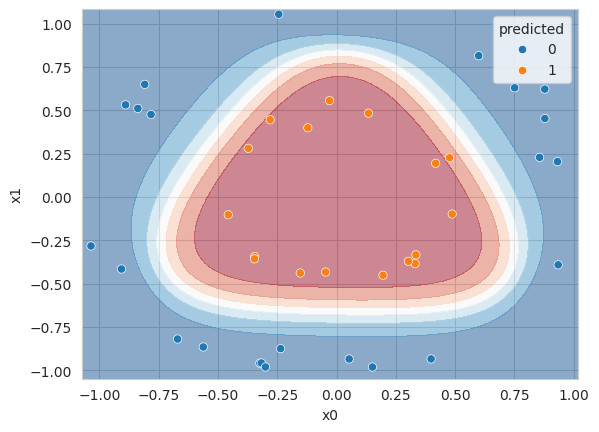

In [30]:
min_x = data['x0'].min()
min_y = data['x1'].min()

max_x = data['x0'].max()
max_y = data['x1'].max()

x_mesh, y_mesh = np.meshgrid(np.linspace(min_x, max_x, 100), np.linspace(min_y, max_y, 100))
class_probs = model(Variable(torch.from_numpy(np.c_[x_mesh.ravel(), y_mesh.ravel()]).float()))
#print(logits)

#probs = torch.softmax(logits, dim=0)
z = np.array(class_probs.detach().numpy()).reshape(x_mesh.shape)

test['predicted'] = [predict(x) for x in model(torch.from_numpy(test[['x0','x1']].values).float()).detach().numpy()]

fig, ax = plt.subplots()
ax.contourf(x_mesh, y_mesh, z, cmap='RdBu_r', alpha=0.5)
sns.scatterplot(x='x0', y='x1', data=test, hue='predicted')

## Non-Linear Node Classification with Neural Networks

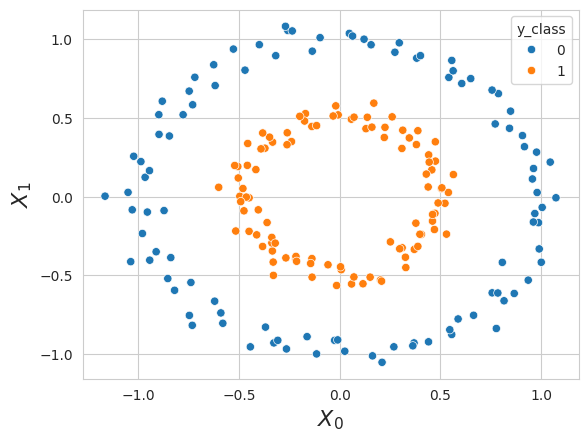

In [31]:
x, c = make_circles(n_samples=200, noise = 0.05, factor = 0.5)
data = pd.DataFrame( {'x0': x[:,0], 'x1': x[:,1], 'y_class': c })

sns.scatterplot(x='x0', y='x1', data=data, hue='y_class')
plt.xlabel(r'$X_0$', fontsize=16)
plt.ylabel(r'$X_1$', fontsize=16);

In [32]:
def euclidean_dist(x, y):
    return np.linalg.norm(x-y)

def soft_rule(dist, **kwargs):
    p = kwargs['beta'] * np.exp(-dist/kwargs['alpha'])
    if np.random.random() <= p:
        return True
    else:
        return False

In [33]:
net = pp.Network(directed=False)
for i, row in data.iterrows():
    net.add_node(str(i), pos=np.array([row['x0'], row['x1']]), g=c[i])
for v in net.nodes:
    for w in net.nodes:
        if soft_rule(euclidean_dist(v['pos'], w['pos']), alpha=0.05, beta=50) and v.uid != w.uid:
            net.add_edge(v, w)
print(net)

Uid:			0x7fbf7f415ed0
Type:			Network
Directed:		False
Multi-Edges:		False
Number of nodes:	200
Number of edges:	1177


In [34]:
colors = {}
colors[0] = 'orange'
colors[1] = 'CornflowerBlue'
for v in net.nodes:
    v['color'] = colors[v['g']]
net.plot(edge_color='grey')

In [35]:
nodes = [(v.uid, v['g']) for v in net.nodes]
data = pd.DataFrame(nodes, columns=['v', 'g'])

train, test = train_test_split(data, test_size=0.3)

In [36]:
def laplacian(network):
    A = pp.algorithms.adjacency_matrix(network, weight=False)
    D = sp.sparse.diags(pp.statistics.degree_sequence(network))
    L = D - A
    return L

def normalized_laplacian(network: pp.Network):
    I = sp.sparse.identity(network.number_of_nodes())
    A = network.adjacency_matrix()
    D_inv_sqrt = sp.sparse.diags(pp.statistics.degree_sequence(network)).power(-0.5)
    L = I- D_inv_sqrt * A * D_inv_sqrt
    return L

def laplacian_embedding(network, laplacian, d=None):
    """Function that returns a vector representation of all nodes based on the entries of eigenvectors of the laplacian"""
    
    if d == None:
        d = network.number_of_nodes()-1
    
    ew, ev = sp.linalg.eig(laplacian.todense())

    # get eigenvectors and eigenvalues in ascending order, skipping the first
    index = np.argsort(ew)[1:]
    ev = ev[:,index]
    ew = ew[index]

    #ev = normalize(ev, p=2)

    vecs = {}
    for v in network.nodes.uids:
        # embedding x_ of node i in m-dimensional vector space is given by 
        # i-th component in the first m eigenvectors 
        # (ignoring the eigenvector corrresponding to zero eigenvalue)
        #embedding = ev[:,:d]
        vecs[v] = ev[network.nodes.index[v],:d].real
        for i in range(d):
            vecs[v][i] /= ew[i].real
        #vecs[v] = np.squeeze(np.asarray(ev[network.nodes.index[v],1:d+1].real))

    return vecs

def assign_features(embedding, df):
    features = []
    for index, row in df.iterrows():
        f = embedding[row['v']]
        for i in range(len(f)):
            df.loc[index, 'x{0}'.format(i)] = f[i]

In [37]:
embedding = laplacian_embedding(net, laplacian(net), d=2)

assign_features(embedding, train)
assign_features(embedding, test)
assign_features(embedding, data)

<Axes: xlabel='x0', ylabel='x1'>

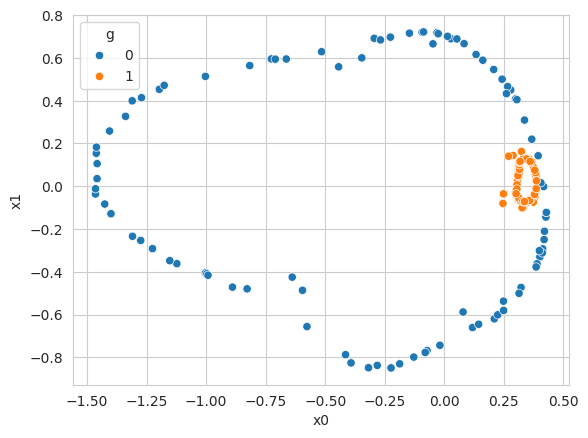

In [38]:
sns.scatterplot(data=data, x='x0', y='x1', hue='g')

In [39]:
train_features = train[['x0', 'x1']]
train_labels = train[['g']]

train_features = torch.tensor(train_features.values, dtype=torch.float32)
train_labels = torch.tensor(train_labels.values, dtype=torch.float32)

In [40]:
model = FFNet(in_ch=2, hidden_dim=6, out_ch=1)

epochs = 500
lrn_rate = 0.1
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lrn_rate)

In [41]:
print("\nStarting training ")

# Set network to training mode
model.train()

indices = np.arange(len(train_features))

losses = []

# one epoch is a complete run of the optimization algorithm
for epoch in range(epochs):
    error = 0
    # in each epoch, we use one `batch` of training samples
    np.random.shuffle(indices)
    for i in indices:

        X = train_features[i].reshape(1,2)
        Y = train_labels[i]
        
        # sets gradients to zero
        optimizer.zero_grad()

        output = model(X)        
        loss = loss_func(output[0], Y)

        # the backward propagation function
        # propagates the error (calculated by the 
        # loss function) backwards through the network

        # autograd will calculate gradients in the 
        # of parameters and store them in the .grad property        
        # parameter gradients are calculated based on partial derivatives of the 
        # loss and activation function
        loss.backward()
        error += loss.detach().numpy()

        # perform parameter update based on current gradients
        # and update rule of optimization algorithm
        optimizer.step()

    losses.append(error)

print("Done training ")


Starting training 
Done training 


<Axes: xlabel='x0', ylabel='x1'>

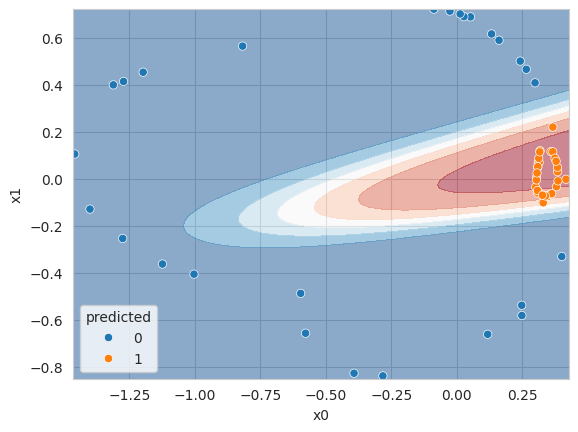

In [42]:
min_x = data['x0'].min()
min_y = data['x1'].min()

max_x = data['x0'].max()
max_y = data['x1'].max()

x_mesh, y_mesh = np.meshgrid(np.linspace(min_x, max_x, 100), np.linspace(min_y, max_y, 100))
class_probs = model(Variable(torch.from_numpy(np.c_[x_mesh.ravel(), y_mesh.ravel()]).float()))

z = np.array(class_probs.detach().numpy()).reshape(x_mesh.shape)

test['predicted'] = [predict(x) for x in model(torch.from_numpy(test[['x0','x1']].values).float()).detach().numpy()]

fig, ax = plt.subplots()
ax.contourf(x_mesh, y_mesh, z, cmap='RdBu_r', alpha=0.5)
sns.scatterplot(x='x0', y='x1', data=test, hue='predicted')

In [43]:
train_nodes = set([x for x in train['v'].values])
test_nodes = set([x for x in test['v'].values])

# color nodes in test set according to prediction
for v in net.nodes:
    if v.uid in train_nodes:
        v['color'] = 'grey'
    else:
        v['color'] = colors[int(test[test['v']==v.uid]['predicted'].iloc[0])]

In [44]:
net.plot(edge_color='grey')